In [ ]:
from qiskit import QuantumCircuit, transpile
import numpy as np
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, errors

from qiskit import QuantumCircuit, transpile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
def dj_function(num_qubits, balanced=True):
    qc = QuantumCircuit(num_qubits + 1)
    
    if np.random.randint(0, 2):
        qc.x(num_qubits)  # Flip output qubit with 50% chance

    if balanced:
        # Create a balanced function
        # Choose half the possible input states
        on_states = np.random.choice(
            range(2**num_qubits),  # numbers to sample from
            2**num_qubits // 2,  # number of samples
            replace=False,  # makes sure states are only sampled once
        )

        def add_cx(qc, bit_string):
            for qubit, bit in enumerate(reversed(bit_string)):
                if bit == "1":
                    qc.x(qubit)
            return qc

        for state in on_states:
            qc.barrier()  # Barriers are added to help visualize how the functions are created. They can safely be removed.
            qc = add_cx(qc, f"{state:0b}")
            qc.mcx(list(range(num_qubits)), num_qubits)
            qc = add_cx(qc, f"{state:0b}")

    qc.barrier()
    return qc


In [5]:
def compile_circuit(function: QuantumCircuit):
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    # qc.x(n)  # bug
    qc.x(n)      #1
    qc.h(range(n + 1))
    qc.compose(function, inplace=True)   #2
    qc.h(range(n))        #3
    # qc.x(0)  # bug
    qc.measure(range(n), range(n))
    return qc

In [6]:
def dj_algorithm(function: QuantumCircuit, noise, shots):
    qc = compile_circuit(function)
    simulator = AerSimulator(noise_model=noise)
    qc = qc.decompose(reps=10)
    # qc = transpile(qc, simulator)
    result = simulator.run(qc, shots=shots, memory=True).result()
    # measurements = result.get_memory()
    return result.get_counts(), qc

In [7]:
from math import log2

def calculate_bias_entropy(output_map, unwanted_states):
    total_count = sum(output_map.values())

    bias = 0
    count = 0
    for key, val in output_map.items():
        if key in unwanted_states:
            bias += val / total_count
        count += 1

    entropy = 0
    for key, val in output_map.items():
        if (val == 0):
            continue
        else:
            p = val / total_count
            entropy = entropy - p * log2(p)

    return bias, entropy

In [8]:
def to_bin(number, num_bits):
    return format(number, f'0{num_bits}b')

In [9]:
n=3
unwanted_cons = [to_bin(i,n) for i in range(1, pow(2,n))]
unwanted_bal = [to_bin(0,n)]
unwanted = {'balanced': unwanted_bal,
            'constant': unwanted_cons}
shots=10000
runs=10000

In [10]:
def empty_dict():
    dict = {}
    keys = unwanted_cons+unwanted_bal
    dict = dict.fromkeys(keys, 0)
    return dict

In [11]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

def create_noise_model_final(p):
    noise_model = NoiseModel()

    error = depolarizing_error(4*p/3, 1)
    noise_model.add_all_qubit_quantum_error(error, ['id', 'u', 'u1', 'u2', 'u3', 'rz', 'sx', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg'])
    
    # 2. Two-qubit errors via composed channels
    error = depolarizing_error(16*p/15, 2)
    noise_model.add_all_qubit_quantum_error(error, ['cx'])
    
    return noise_model


# Balanced

#### Threshold calculation

In [12]:
num_ops_bal = []
for _ in range(runs):
    f = dj_function(n, balanced=1)
    qc = compile_circuit(f)
    qc = qc.decompose(reps=10)
    ops = qc.count_ops()
    count=0
    for key,val in ops.items():
        if key!='barrier' and key!='measure':
            count+=val
    num_ops_bal.append(count)

num_ops_bal = np.array(num_ops_bal)
num_gates_bal = num_ops_bal.mean()
print("Average number of gate operations:", num_gates_bal)
expected_thresh_bal = (1 - (2**n - len(unwanted['balanced']))/2**n)/num_gates_bal
print('Expected Threshold: ', expected_thresh_bal)

Average number of gate operations: 144.4772
Expected Threshold:  0.0008651884172727599


#### Noise models

In [35]:
noise_bal = {'no' : None,
        'below_thresh' : create_noise_model_final(expected_thresh_bal/2),
             'thresh' : create_noise_model_final(expected_thresh_bal)}

## Count Histograms

#### Without Noise

In [14]:
dist_bal_nonoise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=1)
    result, qc = dj_algorithm(f, noise_bal['no'], shots)
    for key, val in result.items():
        dist_bal_nonoise[key] += val

arr_bal_nonoise = calculate_bias_entropy(dist_bal_nonoise, unwanted['balanced'])
print("Bias: ", arr_bal_nonoise[0], " Entropy: ",arr_bal_nonoise[1])
for key, val in dist_bal_nonoise.items():
    dist_bal_nonoise[key] = val/(shots*runs)

Bias:  0.0  Entropy:  2.8072004064245135


C:\Users\devra\AppData\Local\Temp\ipykernel_26164\3511394500.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_bal_nonoise.show()


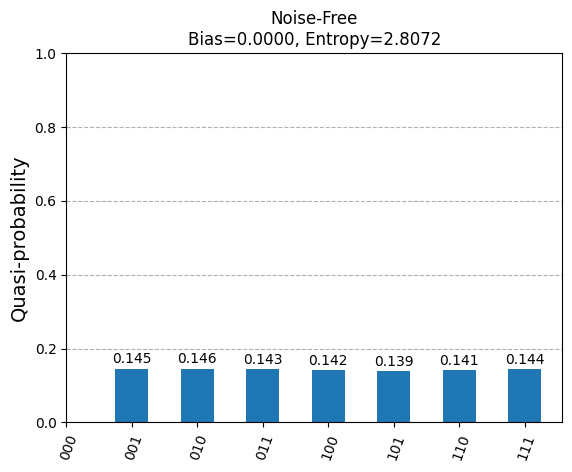

In [45]:
%matplotlib inline
fig_bal_nonoise = plot_histogram(dist_bal_nonoise, title=f"Noise-Free\nBias={arr_bal_nonoise[0]:.4f}, Entropy={arr_bal_nonoise[1]:.4f}")

# Set the y-axis range to go up to 1
ax = fig_bal_nonoise.gca()  # Get the current axes
ax.set_ylim(0, 1)  # Set y-axis limits

# Show the modified plot
fig_bal_nonoise.show()

#### With Noise below threshold

In [37]:
dist_bal_low_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=1)
    result, qc = dj_algorithm(f, noise_bal['below_thresh'], shots)
    for key, val in result.items():
        dist_bal_low_noise[key] += val

arr_bal_low_noise = calculate_bias_entropy(dist_bal_low_noise, unwanted['balanced'])
print(f"Bias : {arr_bal_low_noise[0]}, Entropy : {arr_bal_low_noise[1]}")
for key, val in dist_bal_low_noise.items():
    dist_bal_low_noise[key] = val/(shots*runs)

Bias : 0.0096509, Entropy : 2.858487679174898


C:\Users\devra\AppData\Local\Temp\ipykernel_26164\925765663.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_bal_low_noise.show()


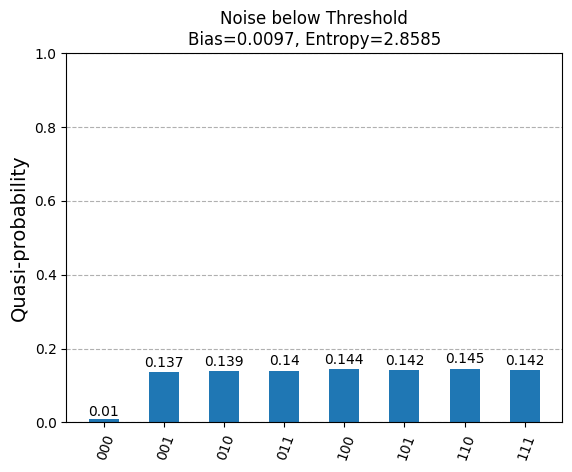

In [47]:
fig_bal_low_noise = plot_histogram(dist_bal_low_noise, title=f"Noise below Threshold\nBias={arr_bal_low_noise[0]:.4f}, Entropy={arr_bal_low_noise[1]:.4f}")

# Set the y-axis range to go up to 1
ax = fig_bal_low_noise.gca()  # Get the current axes
ax.set_ylim(0, 1)  # Set y-axis limits

# Show the modified plot
fig_bal_low_noise.show()

#### With Noise at Threshold

In [ ]:
dist_bal_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=1)
    result, qc = dj_algorithm(f, noise_bal['thresh'], shots)
    for key, val in result.items():
        dist_bal_noise[key] += val

arr_bal_noise = calculate_bias_entropy(dist_bal_noise, unwanted['balanced'])
print(f"Bias : {arr_bal_noise[0]}, Entropy : {arr_bal_noise[1]}")
for key, val in dist_bal_noise.items():
    dist_bal_noise[key] = val/(shots*runs)

Bias : 0.01866498, Entropy : 2.888684073503642


C:\Users\devra\AppData\Local\Temp\ipykernel_26164\3061721735.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_bal_noise.show()


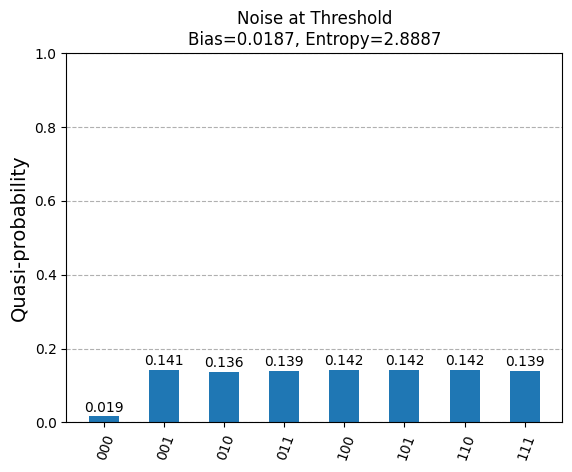

In [48]:
fig_bal_noise = plot_histogram(dist_bal_noise, title=f"Noise at Threshold\nBias={arr_bal_noise[0]:.4f}, Entropy={arr_bal_noise[1]:.4f}")

# Set the y-axis range to go up to 1
ax = fig_bal_noise.gca()  # Get the current axes
ax.set_ylim(0, 1)  # Set y-axis limits

# Show the modified plot
fig_bal_noise.show()

### Entropy vs Noise

In [18]:
runs = 1000
entropies_bal = []
biases_bal = []
noise_levels_bal = [j/10000.0 for j in range(0, 101, 2)]
for i in tqdm(noise_levels_bal, desc="Processing Noise Levels"):
    dist_bal_evn = empty_dict()
    noise_model = create_noise_model_final(i)
    for _ in range(runs):
        f = dj_function(n, balanced=1)  #bal
        result = dj_algorithm(f, noise_model, shots)[0]
        for key, val in result.items():
            dist_bal_evn[key] += val
    arr_bal_evn = calculate_bias_entropy(dist_bal_evn, unwanted['balanced'])
    biases_bal.append(arr_bal_evn[0])
    entropies_bal.append(arr_bal_evn[1])
runs = 10000

Processing Noise Levels: 100%|██████████| 51/51 [1:20:30<00:00, 94.73s/it] 


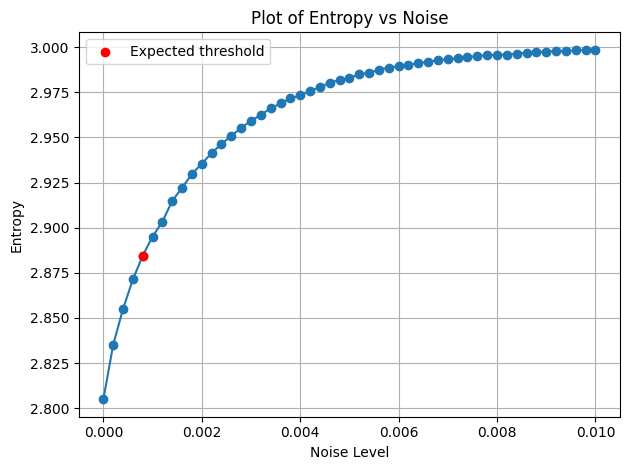

In [ ]:
# Plot the data
plt.plot(noise_levels_bal, entropies_bal, marker='o')
plt.xlabel('Noise Level')
plt.ylabel('Entropy')
plt.title('Plot of Entropy vs Noise')

# Target noise level and entropy value
# noise_level_target = round(expected_thresh_bal, 4)
noise_level_target = 0.0008
entropy_value = entropies_bal[noise_levels_bal.index(noise_level_target)]  # Find corresponding entropy value
plt.scatter([noise_level_target], [entropy_value], color='red', zorder=2, label=f'at Expected threshold')
# plt.text(noise_level_target + 0.0002, entropy_value-0.001, f'({noise_level_target:.4f}, {entropy_value:.4f})', 
        #  color='black', fontsize=10)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Constant

#### Threshold calculation

In [21]:
num_ops_cons = []
for _ in range(runs):
    f = dj_function(n, balanced=0)
    qc = compile_circuit(f)
    qc = qc.decompose(reps=10)
    ops = qc.count_ops()
    count=0
    for key,val in ops.items():
        if key!='barrier' and key!='measure':
            count+=val
    num_ops_cons.append(count)

num_ops_cons = np.array(num_ops_cons)
num_gates_cons = num_ops_cons.mean()
print("Average number of gate operations:", num_gates_cons)
expected_thresh_cons = (1 - (2**n - len(unwanted['constant']))/2**n)/num_gates_cons
print('Expected Threshold: ', expected_thresh_cons)

Average number of gate operations: 8.488
Expected Threshold:  0.10308671065032989


#### Noise models

In [39]:
noise_cons = {'no' : None,
              'below_thresh' : create_noise_model_final(expected_thresh_cons/2),
              'thresh' : create_noise_model_final(expected_thresh_cons)}

## Count Histograms

#### Without Noise

In [64]:
dist_cons_nonoise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=0)
    result, qc = dj_algorithm(f, noise_cons['no'], shots)
    for key, val in result.items():
        dist_cons_nonoise[key] += val

arr_cons_nonoise = calculate_bias_entropy(dist_cons_nonoise, unwanted['constant'])   # the second argument is a list of unwanted states
print(f"Bias : {arr_cons_nonoise[0]}, Entropy : {arr_cons_nonoise[1]}")
for key, val in dist_cons_nonoise.items():
    dist_cons_nonoise[key] = val/(shots*runs)


Bias : 0.0, Entropy : 0.0


C:\Users\devra\AppData\Local\Temp\ipykernel_26164\55340877.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cons_nonoise.show()


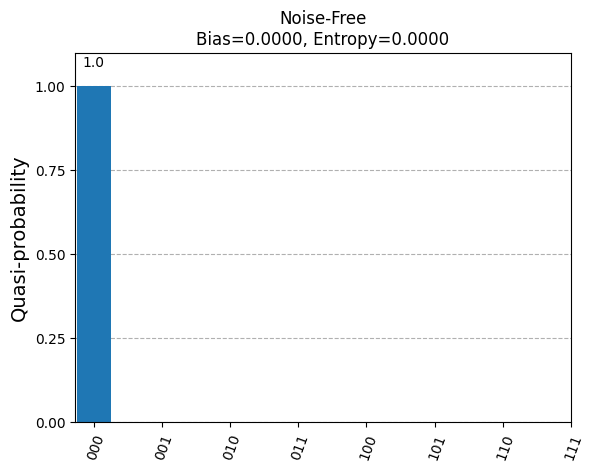

In [65]:
fig_cons_nonoise = plot_histogram(dist_cons_nonoise, title=f"Noise-Free\nBias={arr_cons_nonoise[0]:.4f}, Entropy={arr_cons_nonoise[1]:.4f}")

# Set the y-axis range to go up to 1
ax = fig_cons_nonoise.gca()  # Get the current axes
ax.set_ylim(0, 1.1)  # Set y-axis limits

# Show the modified plot
fig_cons_nonoise.show()

#### With Noise below threshold

In [40]:
dist_cons_low_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=0)
    result, qc = dj_algorithm(f, noise_cons['below_thresh'], shots)
    for key, val in result.items():
        dist_cons_low_noise[key] += val

arr_cons_low_noise = calculate_bias_entropy(dist_cons_low_noise, unwanted['constant'])   # the second argument is a list of unwanted states
print(f"Bias : {arr_cons_low_noise[0]}, Entropy : {arr_cons_low_noise[1]}")
for key, val in dist_cons_low_noise.items():
    dist_cons_low_noise[key] = val/(shots*runs)


Bias : 0.18614709000000004, Entropy : 1.056504813310706


C:\Users\devra\AppData\Local\Temp\ipykernel_26164\1693276268.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cons_low_noise.show()


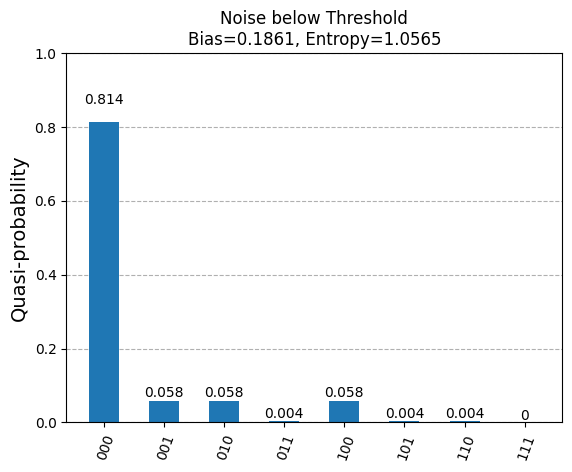

In [50]:
fig_cons_low_noise = plot_histogram(dist_cons_low_noise, title=f"Noise below Threshold\nBias={arr_cons_low_noise[0]:.4f}, Entropy={arr_cons_low_noise[1]:.4f}")

# Set the y-axis range to go up to 1
ax = fig_cons_low_noise.gca()  # Get the current axes
ax.set_ylim(0, 1)  # Set y-axis limits

# Show the modified plot
fig_cons_low_noise.show()

#### With noise

In [ ]:
dist_cons_noise = empty_dict()
for _ in range(runs):
    f = dj_function(n, balanced=0)
    result, qc = dj_algorithm(f, noise_cons['thresh'], shots)
    
    for key, val in result.items():
        dist_cons_noise[key] += val

arr_cons_noise = calculate_bias_entropy(dist_cons_noise, unwanted['constant'])   # the second argument is a list of unwanted states
print(f"Bias : {arr_cons_noise[0]}, Entropy : {arr_cons_noise[1]}")
for key, val in dist_cons_noise.items():
    dist_cons_noise[key] = val/(shots*runs)


Bias : 0.33706433, Entropy : 1.6561538202074617


C:\Users\devra\AppData\Local\Temp\ipykernel_26164\3264124572.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_cons_noise.show()


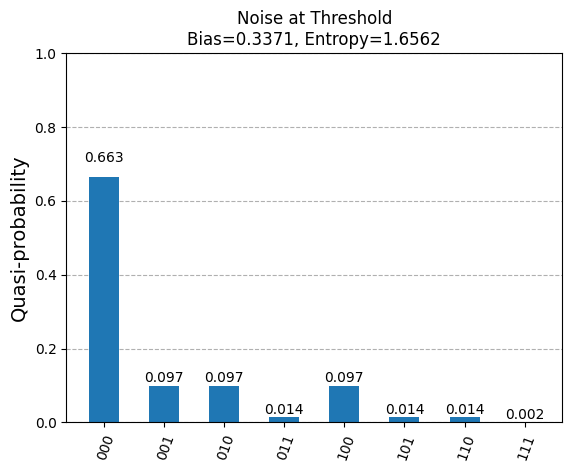

In [51]:
fig_cons_noise = plot_histogram(dist_cons_noise, title=f"Noise at Threshold\nBias={arr_cons_noise[0]:.4f}, Entropy={arr_cons_noise[1]:.4f}")

# Set the y-axis range to go up to 1
ax = fig_cons_noise.gca()  # Get the current axes
ax.set_ylim(0, 1)  # Set y-axis limits

# Show the modified plot
fig_cons_noise.show()

### Entropy vs Noise

In [27]:
runs = 1000
entropies_cons = []
biases_cons = []
noise_levels_cons = [j/100.0 for j in range(0, 51)]
for i in tqdm(noise_levels_cons, desc="Processing Noise Levels"):
    dist_cons_evn = empty_dict()
    noise_model = create_noise_model_final(i)
    for _ in range(runs):
        f = dj_function(n, balanced=0)
        result = dj_algorithm(f, noise_model, shots)[0]
        for key, val in result.items():
            dist_cons_evn[key] += val
    arr_cons_evn = calculate_bias_entropy(dist_cons_evn, unwanted['constant'])
    biases_cons.append(arr_cons_evn[0])
    entropies_cons.append(arr_cons_evn[1])
runs = 10000

Processing Noise Levels: 100%|██████████| 51/51 [23:19<00:00, 27.45s/it]


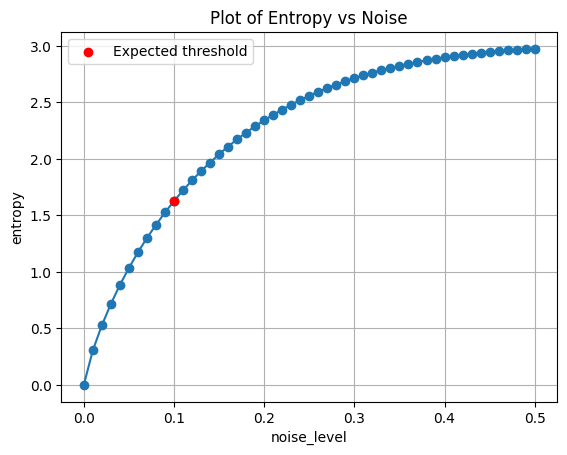

In [ ]:
plt.plot(noise_levels_cons, entropies_cons, marker='o')  # marker='o' adds points for each x-y pair
plt.xlabel('noise_level')
plt.ylabel('entropy')
plt.title('Plot of Entropy vs Noise')

# Target noise level and entropy value
# noise_level_target = round(expected_thresh_cons, 2)
noise_level_target = 0.1
entropy_value = entropies_cons[noise_levels_cons.index(noise_level_target)]  # Find corresponding entropy value
plt.scatter([noise_level_target], [entropy_value], color='red', zorder=2, label=f'at Expected threshold')
# plt.text(noise_level_target + 0.01, entropy_value-0.05, f'({noise_level_target:.4f}, {entropy_value:.4f})', 
#          color='black', fontsize=10)

plt.grid(True)
plt.legend()
plt.show()